<a href="https://colab.research.google.com/github/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow/blob/main/cristie_mod6_proj_final_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# **Ciência de Dados: Fundamentos de Machine Learning**
---
---

## **Pós-graduação em Ciência de Dados (2025/2026)**

**Escola Superior de Tecnologia da Universidade Estadual do Amazonas - EST/UEA**
    
**Disciplina:** Fundamentos de Machine Learning

**Prof. Me.:** Mario Bessa

_**Repositório do Projeto Acadêmico no Github:** [e-SUS_Sinan_Mpox_ML-Workflow](https://github.com/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow)_

_**Alunos:**_

- _A. Cristiane R. Lima (Cristie)_
- _José Henrique Santos Cavalcante (Henrique)_

_**Data:** 30 de agosto de 2025_


## **Projeto Final**
Este projeto está dividido em 2 notebooks para contemplar o fluxo completo de pré-modelagem e modelagem para o dataset [e-SUS Sinan/Mpox](https://opendatasus.saude.gov.br/ne/dataset/mpox), seguindo uma estrutura padronizada, do seguinte modo:

- cristie_mod6_proj_final_parte_1.ipynb: Aquisição, Análise Descritiva e Exploratória de Dados (EDA), Pré-processamento (Correção )

Foi desenvolvido a partir do notebook-base apresentado e explicado ao longo as aulas teórico-práticas em laboratório do Professor.

---

💡 **Nota técnica:** O link para o Dicionário de Dados está disponível na seção de *Análise Descritiva*. Recomenda-se mantê-lo aberto para facilitar a interpretação das variáveis.

⚠️ **Observação:** Linhas com o comentário `#debug#` indicam trechos opcionais para testes e inspeções pontuais — como a geração de arquivos `.csv` temporários para verificar o estado do DataFrame após imputações.

📚 **Referência:**  
KELLEHER, John D.; MAC NAMEE, Brian; D’ARCY, Aoife. *Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies*. 2. ed. Cambridge, MA: MIT Press, 2020.


---
### **Contextualização do Projeto**

A Mpox (Monkeypox) é uma doença infecciosa emergente que ganhou atenção internacional devido ao seu potencial de disseminação e impacto na saúde pública. No Brasil, o sistema e-SUS Sinan tem sido fundamental para o registro e monitoramento dos casos, permitindo a construção de bases de dados estruturadas para análise epidemiológica.

Este projeto tem como objetivo aplicar técnicas de aprendizado de máquina para explorar, tratar e modelar os dados disponíveis, com foco na geração de insights preditivos que possam apoiar estratégias de vigilância e resposta. A abordagem adotada contempla desde o pré-processamento e imputação de dados até a construção de modelos supervisionados, seguindo diretrizes metodológicas discutidas em ambiente acadêmico.

---

**Instruções:**

- Realizar os processamentos abaixo:

  - No notebook `cristie_mod6_proj_final_parte_1.ipynb`:
    -  Atividade 1: Limpar dados incorretos
    -  Atividade 2: Imputação de valores faltantes
  - No notebook `cristie_mod6_proj_final_parte_2.ipynb`:
    -  Atividade 3: Codificação de variáveis categóricas (OrdinalEncoder e OneHotEncoder)
    -  Atividade 4: Escalonamento de variáveis numéricas (StandardScaler e MinMaxScaler)
    -  Atividade 5: Balanceamento dos dados (Tomek e Smote)
    -  Atividade 6: Treinamento dos modelos de Machine Learning
    -  Atividade 7: Usar o modelo treinado

## Importa bibliotecas

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns

# Para filtro de variância
from sklearn.feature_selection import VarianceThreshold


# Para garantir X 100% numérico e sem NaN antes de Tomek/SMOTE
from sklearn.impute import SimpleImputer

# Para aplicar TomerkLinks e SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

#import matplotlib.pyplot as plt

## Tarefas preliminares

Montar o Google Drive no Colab

In [3]:
#Montar o Google Drive no Colab
#from google.colab import drive

# Montar o Google Drive na pasta /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


Registra o caminho da pasta do projeto

In [4]:

# Caminho da pasta do projeto (ajuste conforme sua organização)
project_path = "/content/drive/MyDrive/data_mpox_2022_Part1/"

# Conferir se a pasta existe, senão criar
import os
os.makedirs(project_path, exist_ok=True)

print("✅ Drive montado em:", project_path)


✅ Drive montado em: /content/drive/MyDrive/data_mpox_2022_Part1/


## 📂 Desserialização do dataset pré-processado

In [5]:
# 📂 Desserialização do dataset pré-processado

filename = project_path + "mpox_2022_prep.parquet"
df_prep = pd.read_parquet(filename)
print("✅ df_prep carregado com sucesso:", df_prep.shape)

# Visualizar primeiras linhas
df_prep.head(1)

✅ df_prep carregado com sucesso: (10920, 114)


,CLASSI_FIN,SG_UF,SG_UF_NOT,ID_MUNICIP,DT_NOTIFIC,CO_UF_RES,ID_MN_RESI,NU_IDADE_N,CS_SEXO,COMP_SEXUAL,...,CLADO_missing,DOENCA_TRA.1_missing,NU_IDADE_N_missing,CONTAG_CD4_missing,DT_NOTIFIC_missing,DT_SIN_PRI_missing,DT_COLETA_missing,DATA_VACINA_missing,DT_INTERNA_missing,DT_EVOLUCAO_missing
0,1,PB,PB,250750,2022-12-08,25,250750,34,1,1,...,0,0,0,0,0,0,0,1,1,0


---

## **⚙️ Engenharia de Atributos: criando novas variáveis a partir das existentes.**

---



    Resumo da ações:
      1. Explosão de SINTOMA → dummies (min_freq opcional; default preserva todos).
      2. Deltas de datas (sem imputar; respeita NaT).
      3. Agregados clínicos (ISTs, imuno, vacina).
      4. Bins demográficos (idade, região).
      5. Interações (ex.: imuno × sintomas, centralização de delay por região).
      6. Targets (hosp, óbito).
      7. Auditorias.


---


### Engenharia de Atributos — Funções

In [6]:
# ==========================================
# ⚙️ ENGENHARIA DE ATRIBUTOS — FUNÇÕES E EXECUÇÃO
# ==========================================
#import pandas as pd
#import numpy as np

# ------------------------------------------------------------
# 1) Explosão de sintomas em dummies (com min_freq opcional)
# ------------------------------------------------------------
def explode_sintoma_dummies_simple(
    df: pd.DataFrame,
    col: str = "SINTOMA",
    prefix: str = "sx_",
    min_freq: int | None = None
) -> tuple[pd.DataFrame, list]:
    """
    Transforma a coluna de sintomas (strings separadas por vírgula) em colunas dummies (0/1).

    Parâmetros
    ----------
    df : DataFrame
        Base de entrada.
    col : str
        Nome da coluna que contém a lista de sintomas (ex.: "Febre, Cefaleia").
    prefix : str
        Prefixo a ser usado nas colunas dummies geradas (ex.: "sx_").
    min_freq : int | None
        - None → mantém TODOS os sintomas (recomendado para saúde; preserva informação).
        - inteiro ≥1 → mantém apenas sintomas com frequência absoluta ≥ min_freq
                       (útil futuramente para reduzir esparsidade).

    Retorno
    -------
    df_out : DataFrame
        DataFrame original + colunas dummies para cada sintoma selecionado.
    sintomas_cols : list[str]
        Lista com os nomes das colunas de sintomas criadas.
    """
    df_out = df.copy()

    if col not in df_out.columns:
        return df_out, []

    # Lista de sintomas por linha (minúsculas, trim de espaços; ignora strings vazias)
    s_clean = df_out[col].fillna("").astype(str)
    listas = s_clean.str.split(",").apply(lambda xs: [t.strip().lower() for t in xs if t.strip() != ""])

    # Frequência dos termos
    freq = pd.Series([t for sub in listas for t in sub]).value_counts()

    # Seleção por min_freq (se None → todos)
    if min_freq is None:
        termos = freq.index
    else:
        termos = freq[freq >= int(min_freq)].index

    # Criação de dummies (0/1) linha a linha
    for termo in termos:
        c = f"{prefix}{termo.replace(' ', '_')}"
        df_out[c] = listas.apply(lambda L: int(termo in L)).astype("Int64")

    sintomas_cols = [c for c in df_out.columns if c.startswith(prefix)]
    return df_out, sintomas_cols


# ------------------------------------------------------------
# 2) Features derivadas de datas (sem imputar datas)
# ------------------------------------------------------------
def add_date_features(
    df: pd.DataFrame,
    col_notif: str = "DT_NOTIFIC",
    col_inicio: str = "DT_SIN_PRI",
    col_evol: str = "DT_EVOLUCAO",
    col_intern: str = "DT_INTERNA",
    create_missing_flags: bool = True
) -> pd.DataFrame:
    """
    Cria deltas de tempo (em dias) a partir de colunas de datas — sem imputação.
    Se a linha não tiver ambas as datas válidas, o delta fica NaN.

    Parâmetros
    ----------
    df : DataFrame
        Base de entrada (datas podem estar em string; serão convertidas durante o cálculo).
    col_notif, col_inicio, col_evol, col_intern : str
        Nomes das colunas de datas conforme o dicionário.
    create_missing_flags : bool
        Se True, mantém/gera indicadores *_missing (0/1) para cada coluna de data original.

    Retorno
    -------
    DataFrame com as colunas:
      - delay_notif        = DT_NOTIFIC - DT_SIN_PRI
      - tempo_internacao   = DT_EVOLUCAO - DT_INTERNA
      - duracao_caso       = DT_EVOLUCAO - DT_SIN_PRI
    """
    out = df.copy()

    # Flags de ausência (se existirem as colunas)
    def _flag(col):
        if create_missing_flags and col in out.columns:
            out[f"{col}_missing"] = out[col].isna().astype("Int64")

    for c in [col_notif, col_inicio, col_evol, col_intern]:
        _flag(c)

    # Converte sob demanda apenas para calcular deltas
    to_dt = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True)

    if {col_notif, col_inicio}.issubset(out.columns):
        out["delay_notif"] = (to_dt(out[col_notif]) - to_dt(out[col_inicio])).dt.days

    if {col_evol, col_intern}.issubset(out.columns):
        out["tempo_internacao"] = (to_dt(out[col_evol]) - to_dt(out[col_intern])).dt.days

    if {col_evol, col_inicio}.issubset(out.columns):
        out["duracao_caso"] = (to_dt(out[col_evol]) - to_dt(out[col_inicio])).dt.days

    return out


# ------------------------------------------------------------
# 3) Agregados clínicos (ISTs, imunossupressão, vacinação)
# ------------------------------------------------------------
def add_clinical_aggregates(
    df: pd.DataFrame,
    ist_cols: list | None = None,
    col_imuno: str = "PAC_IMUNOSSUP",
    col_vacina: str = "VACINA"
) -> pd.DataFrame:
    """
    Cria agregações clínicas:

    - ist_any   : 1 se pelo menos uma IST específica = 1; 0 caso contrário (ignora NaN ao somar/max).
    - ist_count : soma das ISTs específicas (contagem).
    - imune_risco:
        PAC_IMUNOSSUP (1,2,3) → 1; 4→0; outros (9/NaN) → NA.
    - vacina_qualquer:
        VACINA in {1,2,3} → 1; VACINA==4 → 0; caso contrário → NA.

    Parâmetros
    ----------
    df : DataFrame
    ist_cols : list | None
        Lista explícita de colunas de ISTs. Se None, usa o conjunto padrão do mpox_2022.
    col_imuno : str
        Nome da coluna de imunossupressão.
    col_vacina : str
        Nome da coluna de vacinação.

    Retorno
    -------
    DataFrame com novas colunas: ist_any, ist_count, imune_risco, vacina_qualquer.
    """
    out = df.copy()

    if ist_cols is None:
        ist_cols = [
            "GONORREIA","CLAMIDEA","SIFILIS","HERPES_GENITAL","CANCRO_MOLE",
            "TRICHOMOMAS_VAGINALS","LINFOGRANULOMA","MYCOPLASMA_GENITAL",
            "HPV","DIP","DONOVANOSE","HTLV","VERRUGA_GENITAL"
        ]
    ist_cols = [c for c in ist_cols if c in out.columns]

    if ist_cols:
        out["ist_any"] = out[ist_cols].max(axis=1, skipna=True).astype("Int64")
        out["ist_count"] = out[ist_cols].sum(axis=1, skipna=True).astype("Int64")

    if col_imuno in out.columns:
        m = out[col_imuno].map({1:1, 2:1, 3:1, 4:0})
        out["imune_risco"] = m.astype("Int64")

    if col_vacina in out.columns:
        v = pd.Series(pd.NA, index=out.index, dtype="Int64")
        v = v.mask(out[col_vacina].isin([1,2,3])==True, 1)
        v = v.mask(out[col_vacina].eq(4)==True, 0)
        out["vacina_qualquer"] = v

    return out


# ------------------------------------------------------------
# 4) Bins demográficos / Região (UF→região)
# ------------------------------------------------------------
def add_demo_bins(
    df: pd.DataFrame,
    col_idade: str = "NU_IDADE_N",
    col_uf: str = "SG_UF"
) -> pd.DataFrame:
    """
    Cria faixas etárias e região (a partir de SG_UF).
    - faixa_etaria: categorias textuais (0–9, 10–17, 18–29, 30–39, 40–49, 50–59, 60+).
      (Mantém NaN quando NU_IDADE_N ausente).
    - regiao: Norte, Nordeste, Centro-Oeste, Sudeste, Sul (NaN se SG_UF ausente ou desconhecido).

    Parâmetros
    ----------
    df : DataFrame
    col_idade : str
        Nome da coluna de idade (anos).
    col_uf : str
        Nome da coluna de UF (sigla).

    Retorno
    -------
    DataFrame com 'faixa_etaria' (category) e 'regiao' (category).
    """
    out = df.copy()

    # Faixas etárias (ajustáveis)
    if col_idade in out.columns:
        bins = [-np.inf, 9, 17, 29, 39, 49, 59, np.inf]
        labels = ["0-9","10-17","18-29","30-39","40-49","50-59","60+"]
        out["faixa_etaria"] = pd.cut(out[col_idade], bins=bins, labels=labels).astype("category")

    # Mapeamento UF → Região (IBGE)
    uf_regiao = {
        # Norte
        "AC":"Norte","AP":"Norte","AM":"Norte","PA":"Norte","RO":"Norte","RR":"Norte","TO":"Norte",
        # Nordeste
        "AL":"Nordeste","BA":"Nordeste","CE":"Nordeste","MA":"Nordeste","PB":"Nordeste",
        "PE":"Nordeste","PI":"Nordeste","RN":"Nordeste","SE":"Nordeste",
        # Centro-Oeste
        "DF":"Centro-Oeste","GO":"Centro-Oeste","MS":"Centro-Oeste","MT":"Centro-Oeste",
        # Sudeste
        "ES":"Sudeste","MG":"Sudeste","RJ":"Sudeste","SP":"Sudeste",
        # Sul
        "PR":"Sul","RS":"Sul","SC":"Sul",
    }
    if col_uf in out.columns:
        out["regiao"] = out[col_uf].map(uf_regiao).astype("category")

    return out


# ------------------------------------------------------------
# 5) Interações (exemplos pragmáticos)
# ------------------------------------------------------------
def add_interactions(
    df: pd.DataFrame,
    sintomas_prefix: str = "sx_",
    center_delay_by: str = "regiao"
) -> pd.DataFrame:
    """
    Cria interações/transformações simples:

    - sintoma_count: soma dos dummies de sintomas (se existirem colunas com prefixo sintomas_prefix).
    - imune_risco_x_sintomas: produto de imune_risco * sintoma_count (se ambas existirem).
    - delay_notif_centered_regiao: delay_notif centrado pela média da região (se 'regiao' existir).

    Parâmetros
    ----------
    df : DataFrame
    sintomas_prefix : str
        Prefixo que identifica as colunas dummies de sintomas (default 'sx_').
    center_delay_by : str
        Coluna categórica para centralizar delay_notif por grupo (default 'regiao').

    Retorno
    -------
    DataFrame com novas colunas se aplicáveis.
    """
    out = df.copy()

    # Conta dummies de sintomas
    sint_cols = [c for c in out.columns if c.startswith(sintomas_prefix)]
    if sint_cols:
        out["sintoma_count"] = out[sint_cols].sum(axis=1, skipna=True).astype("Int64")

    # Interação com imunossupressão
    if {"imune_risco","sintoma_count"}.issubset(out.columns):
        # Usa 0 para NA ao multiplicar; resultado volta a Int64 com NA onde ambos eram NA
        tmp = out["imune_risco"].fillna(0) * out["sintoma_count"].fillna(0)
        tmp = tmp.mask(out["imune_risco"].isna() & out["sintoma_count"].isna(), pd.NA)
        out["imune_risco_x_sintomas"] = tmp.astype("Int64")

    # Centralização de delay_notif por região (ou outra coluna categórica)
    if "delay_notif" in out.columns and center_delay_by in out.columns:
        out["delay_notif_centered_regiao"] = (
            out["delay_notif"] - out.groupby(center_delay_by)["delay_notif"].transform("mean")
        )

    return out


# ------------------------------------------------------------
# 6) Targets (variáveis-alvo binárias)
# ------------------------------------------------------------
def add_targets(
    df: pd.DataFrame,
    col_hosp: str = "HOSPITAL",
    col_evol: str = "EVOLUCAO"
) -> pd.DataFrame:
    """
    Cria variáveis-alvo padronizadas para classificação:

    - target_hosp      : 1 se HOSPITAL == 1; 0 caso contrário (Int64 com NA onde não há dado).
    - target_obito_any : 1 se EVOLUCAO ∈ {1 (óbito MPX), 3 (óbito outra causa)}; 0 caso contrário.
    - target_obito_mpx : 1 se EVOLUCAO == 1; 0 caso contrário.

    Parâmetros
    ----------
    df : DataFrame
    col_hosp : str
        Nome da coluna de hospitalização (código).
    col_evol : str
        Nome da coluna de evolução (código).

    Retorno
    -------
    DataFrame com as três colunas de target.
    """
    out = df.copy()

    if col_hosp in out.columns:
        t = out[col_hosp].eq(1)
        out["target_hosp"] = t.where(out[col_hosp].notna(), pd.NA).astype("Int64")

    if col_evol in out.columns:
        any_obito = out[col_evol].isin([1,3])
        out["target_obito_any"] = any_obito.where(out[col_evol].notna(), pd.NA).astype("Int64")
        mpx = out[col_evol].eq(1)
        out["target_obito_mpx"] = mpx.where(out[col_evol].notna(), pd.NA).astype("Int64")

    return out


# ------------------------------------------------------------
# 7) Auditorias
# ------------------------------------------------------------
def audit_sintomas(df: pd.DataFrame, sintomas_cols: list[str]) -> pd.DataFrame:
    """
    Auditoria das dummies de sintomas:
    - non_nulls, sum_positives, percent_positives
    - status: marca colunas sempre-zero / sempre-NaN
    """
    if not sintomas_cols:
        return pd.DataFrame({"msg": ["Sem colunas de sintomas (prefixo não encontrado)."]})

    audit = pd.DataFrame({
        "non_nulls": df[sintomas_cols].notna().sum(),
        "sum_positives": df[sintomas_cols].sum(),
        "percent_positives": df[sintomas_cols].mean() * 100
    })
    audit["status"] = "-"
    audit.loc[audit["sum_positives"] == 0, "status"] = "⚠️ Sempre 0"
    audit.loc[audit["non_nulls"] == 0, "status"] = "⚠️ Sempre NaN"
    return audit.sort_values("percent_positives", ascending=False)


def audit_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Checagem rápida de presença e sanidade das principais novas features.
    Retorna um pequeno quadro-resumo (counts/NA/descrição de colunas-chave).
    """
    cols_check = [
        "delay_notif","tempo_internacao","duracao_caso",
        "ist_any","ist_count","imune_risco","vacina_qualquer",
        "faixa_etaria","regiao","sintoma_count","imune_risco_x_sintomas",
        "delay_notif_centered_regiao",
        "target_hosp","target_obito_any","target_obito_mpx"
    ]
    cols_check = [c for c in cols_check if c in df.columns]
    if not cols_check:
        return pd.DataFrame({"msg": ["Nenhuma coluna derivada encontrada para auditar."]})

    out = []
    for c in cols_check:
        s = df[c]
        out.append({
            "col": c,
            "dtype": str(s.dtype),
            "non_null": int(s.notna().sum()),
            "na": int(s.isna().sum()),
            "unique": int(s.nunique(dropna=True)),
            "sample_values": s.dropna().unique()[:5] if s.nunique(dropna=True) <= 10 else "many"
        })
    return pd.DataFrame(out).set_index("col")

### **Estrutura de Execução (orquestra todas as etapas)**

Neste momento como ainda está-se a explorar e atuar na Engenharia de Atributos, melhor manter todos os dummies de sintomas

In [7]:
# ------------------------------------------------------------
# 8) PIPELINE DE EXECUÇÃO (orquestra todas as etapas)
# ------------------------------------------------------------
def run_feature_engineering_pipeline(
    df: pd.DataFrame,
    sintomas_min_freq: int | None = None
) -> tuple[pd.DataFrame, dict]:
    """
    Executa a Engenharia de Atributos end-to-end:

    Etapas:
      1. Explosão de SINTOMA → dummies (min_freq opcional; default preserva todos).
      2. Deltas de datas (sem imputar; respeita NaT).
      3. Agregados clínicos (ISTs, imuno, vacina).
      4. Bins demográficos (idade, região).
      5. Interações (ex.: imuno × sintomas, centralização de delay por região).
      6. Targets (hosp, óbito).
      7. Auditorias.

    Parâmetros
    ----------
    df : DataFrame
        DataFrame pós-imputação/limpeza.
    sintomas_min_freq : int | None
        Cutoff para filtrar sintomas raros (None = mantém todos).

    Retorno
    -------
    df_feat : DataFrame
        DataFrame final enriquecido com todas as features derivadas.
    info : dict
        Dicionário com artefatos úteis:
          - 'sintomas_cols': lista de colunas dummies geradas
          - 'audit_sintomas': DataFrame de auditoria de sintomas
          - 'audit_features': DataFrame de auditoria final de features
    """
    # 1) Sintomas → dummies
    df1, sx_cols = explode_sintoma_dummies_simple(df, col="SINTOMA", prefix="sx_", min_freq=sintomas_min_freq)

    # 2) Datas → deltas
    df2 = add_date_features(df1)

    # 3) Agregados clínicos
    df3 = add_clinical_aggregates(df2)

    # 4) Bins demográficos / região
    df4 = add_demo_bins(df3)

    # 5) Interações
    df5 = add_interactions(df4)

    # 6) Targets
    df_feat = add_targets(df5)

    # 7) Auditorias
    audit_sx = audit_sintomas(df_feat, sx_cols)
    audit_ft = audit_feature_engineering(df_feat)

    info = {
        "sintomas_cols": sx_cols,
        "audit_sintomas": audit_sx,
        "audit_features": audit_ft
    }
    return df_feat, info


# ==========================================
# 🚀 EXECUÇÃO REAL NO DATAFRAME
# (assume que já existe mpox_2022_prep como df pós-imputação)
# ==========================================
df0 = df_prep.copy()

# ► Mantém todos os sintomas (literatura/consenso: preservar informação clínica agora)
df_feateng, fe_info = run_feature_engineering_pipeline(df0, sintomas_min_freq=None)

print("\n✔️ Engenharia de atributos concluída:")
print("\nTotal de colunas:", df_feateng.shape[1])
print("Total de linhas :", df_feateng.shape[0])



✔️ Engenharia de atributos concluída:

Total de colunas: 222
Total de linhas : 10920


/tmp/ipython-input-2614682301.py:280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["delay_notif"] - out.groupby(center_delay_by)["delay_notif"].transform("mean")


## **⚙️ Auditoria Pós-Engenharia de Dados**

In [8]:
# Amostra de auditorias
print("\n✔️ Resultado da Auditoria Pós-Engenharia de Dados:")
print("\n[Audit] Dummies de sintomas (top 10 por % positivos):")
print(fe_info["audit_sintomas"].head(10))

print("\n\n[Audit] Quadro-resumo de features derivadas:")
print(fe_info["audit_features"],'\n')


✔️ Resultado da Auditoria Pós-Engenharia de Dados:

[Audit] Dummies de sintomas (top 10 por % positivos):
                    non_nulls  sum_positives  percent_positives status
sx_erupcao_cutanea      10920           7319           67.02381      -
sx_febre                10920           6288          57.582418      -
sx_lesao_genital        10920           4785          43.818681      -
sx_cefaleia             10920           4287          39.258242      -
sx_adenomegalia         10920           3809          34.880952      -
sx_dor_muscular         10920           3551          32.518315      -
sx_astenia              10920           3348          30.659341      -
sx_fraqueza             10920           3219          29.478022      -
sx_lesao_anal           10920           2335          21.382784      -
sx_dor_nas_costas       10920           1946          17.820513      -


[Audit] Quadro-resumo de features derivadas:
                                dtype  non_null     na  unique  \

## 📊 Distribuição das variáveis-alvo binárias

/tmp/ipython-input-1375392988.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


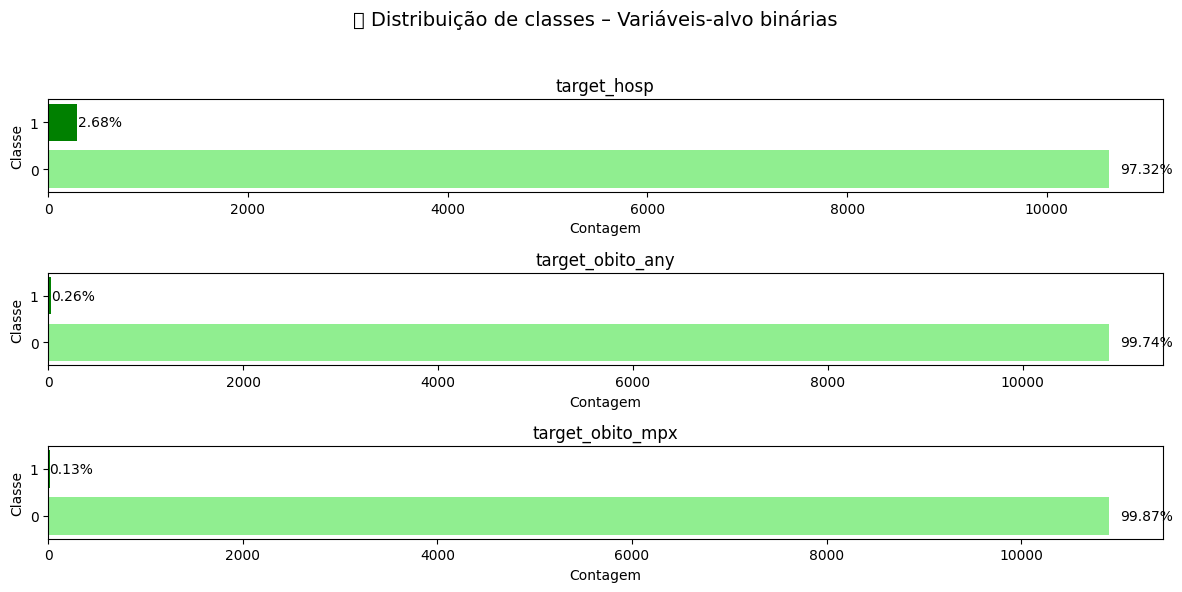

In [9]:
# 📊 Distribuição das variáveis-alvo binárias (df_feateng) – barras horizontais
import matplotlib.pyplot as plt

target_cols = ["target_hosp", "target_obito_any", "target_obito_mpx"]

fig, axes = plt.subplots(len(target_cols), 1, figsize=(12, 6))  # uma coluna, várias linhas

for i, target_col in enumerate(target_cols):
    y = df_feateng[target_col].astype(int)

    counts = y.value_counts().sort_index()
    ratios = (counts / counts.sum() * 100).round(2)

    bars = axes[i].barh([str(k) for k in counts.index], counts.values,
                        color=["lightgreen", "green"], alpha=1)

    # Adicionar percentuais ao lado de cada barra
    for bar, pct in zip(bars, ratios):
        width = bar.get_width()
        axes[i].text(width + (0.01*width), bar.get_y() + bar.get_height()/2,
                     f"{pct:.2f}%", ha="left", va="center", fontsize=10)

    axes[i].set_title(f"{target_col}")
    axes[i].set_xlabel("Contagem")
    axes[i].set_ylabel("Classe")

plt.suptitle("📊 Distribuição de classes – Variáveis-alvo binárias", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 📊 Verificação de Distribuição dos Targets após Engenharia de Atributos

Distribuição (%) de:

target_hosp: {np.int64(0): 97.32, np.int64(1): 2.68}
target_obito_any: {np.int64(0): 99.74, np.int64(1): 0.26}
target_obito_mpx: {np.int64(0): 99.87, np.int64(1): 0.13}


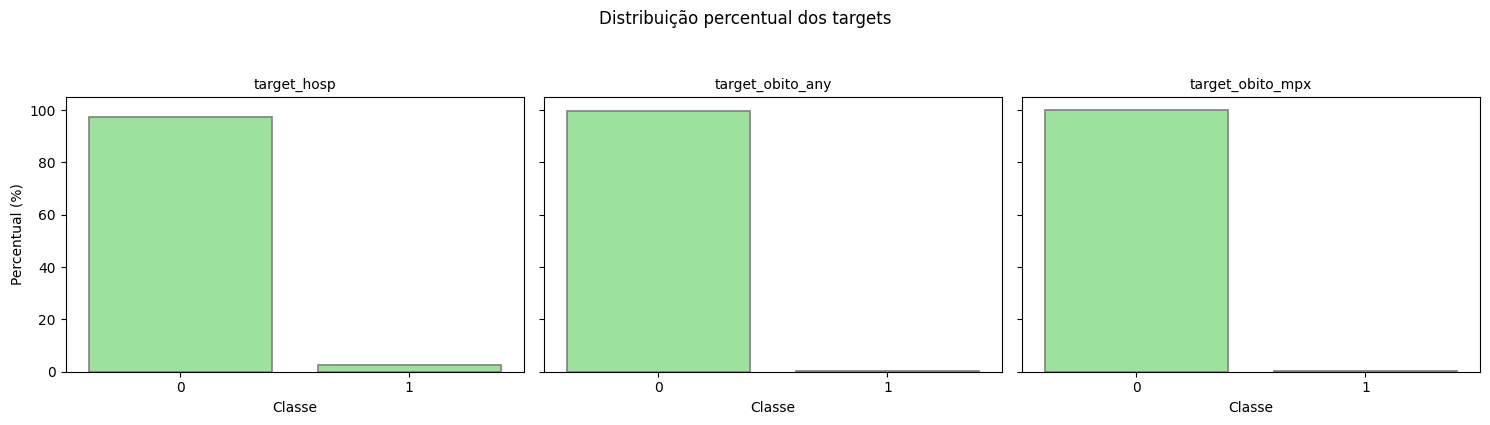

In [10]:
# 📊 Distribuição percentual dos targets + gráficos lado a lado (Seaborn)
#import seaborn as sns
#import matplotlib.pyplot as plt

# Lista de possíveis targets
targets = ["target_hosp", "target_obito_any", "target_obito_mpx"]

# Impressão no console (percentuais simplificados)
print(f"Distribuição (%) de:\n")
for t in targets:
    if t in df_feateng.columns:
        counts = (df_feateng[t].value_counts(normalize=True) * 100).round(2)
        distrib_dict = counts.to_dict()

        print(f"{t}: {distrib_dict}")

# Preparar dados em formato longo para o seaborn
plot_data = []
for t in targets:
    if t in df_feateng.columns:
        counts = (df_feateng[t].value_counts(normalize=True) * 100).round(2)
        for cls, val in counts.items():
            plot_data.append({"Target": t, "Classe": str(cls), "Percentual": val})

df_plot = pd.DataFrame(plot_data)

# Plot com seaborn — um subplot por target
n = df_plot["Target"].nunique()
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=True)

if n == 1:  # garante que axes seja iterável mesmo com 1 target
    axes = [axes]

for ax, target in zip(axes, df_plot["Target"].unique()):
    sns.barplot(
        data=df_plot[df_plot["Target"] == target],
        x="Classe", y="Percentual",
        color="lightgreen", edgecolor="gray", linewidth=1.2, ax=ax
    )
    ax.set_title(f"{target}", fontsize=10)
    ax.set_ylabel("Percentual (%)")
    ax.set_xlabel("Classe")

plt.suptitle("Distribuição percentual dos targets", fontsize=12, y=1.05)
plt.tight_layout()
plt.show()


## 💾 Salvamento Final da Base Pós-Engenharia de Atributos

In [11]:
# 💾 Salvamento final da base pós-engenharia de atributos
output_path = "mpox_2022_feateng.csv"
df_feateng.to_csv(output_path, index=False, encoding="utf-8")
print(f"✔️ Arquivo salvo em: {output_path}")

# 🔍 Verificação pós-salvamento (recarrega e confere shape + distribuição dos targets)
df_check = pd.read_csv(output_path)
print("\nCarregado de volta com sucesso:", df_check.shape)

# Lista de possíveis targets
targets = ["target_hosp", "target_obito_any", "target_obito_mpx"]

for t in targets:
    if t in df_check.columns:
        counts = (df_check[t].value_counts(normalize=True) * 100).round(2)
        distrib_dict = counts.to_dict()
        print(f"Distribuição (%) de {t}: {distrib_dict}")


✔️ Arquivo salvo em: mpox_2022_feateng.csv

Carregado de volta com sucesso: (10920, 222)
Distribuição (%) de target_hosp: {0: 97.32, 1: 2.68}
Distribuição (%) de target_obito_any: {0: 99.74, 1: 0.26}
Distribuição (%) de target_obito_mpx: {0: 99.87, 1: 0.13}


---
##🧹 **Seleção de Atributos — Resumo das Ações**

---

- ✂️ Elimina:

  - Variáveis de datas (`DT_*`),  
  - Identificadores técnicos (`__arquivo_origem__`),  
  - Texto livre cru (`OUTRO_DES`).  

- 📉 Aplica filtro de variância:
  - Remove variáveis numéricas com variância < 1% (sem poder discriminativo:
              `VarianceThreshold(threshold=0.01)`).  

- 🎯 Mantém:
  - Variáveis categóricas para uso em **codificadores** (LabelEncoder / OneHotEncoder).

🧑 Esclarecimento

Filtro de variância:
- A variância de uma feature é uma medida estatística que indica o quanto os valores dessa variável se dispersam em relação à média.

- Atributos com baixa variância tendem a ser pouco informativos, pois não ajudam a distinguir entre diferentes classes ou padrões nos dados.

- Objetivo do filtro é melhorar a qualidade dos dados antes de aplicar algoritmos de aprendizado.

    “Features that do not vary much across the dataset are unlikely to be useful for prediction and can be removed during preprocessing.” — Kelleher et al., 2nd Ed.

In [12]:
# 1. Seleção de Atributos — Remoção inicial de inviáveis + filtro de variância

#import pandas as pd
#from sklearn.feature_selection import VarianceThreshold

# Carrega o dataset pós-engenharia de atributos
df_feateng = pd.read_csv("mpox_2022_feateng.csv")

print(f"[0] Dataset carregado com {df_feateng.shape[1]} variáveis")

print("\nTotal de variáveis após:\n")
# --------------------------
# A) Remover variáveis inviáveis
# --------------------------
inviaveis = [
    "__arquivo_origem__",   # identificador técnico
    "OUTRO_DES"             # texto livre cru (já não entra em modelagem)
] + [c for c in df_feateng.columns if c.startswith("DT_")]  # datas puras

df_reduced = df_feateng.drop(columns=[c for c in inviaveis if c in df_feateng.columns])

print(f"[1] Remoção de inviáveis: {df_reduced.shape[1]} variáveis")

# --------------------------
# B) Filtro de variância
# --------------------------
sel = VarianceThreshold(threshold=0.01)  # <1% de variância → descartar
sel.fit(df_reduced.select_dtypes(include=["int64","float64"]))

variaveis_ok = df_reduced.select_dtypes(include=["int64","float64"]).columns[sel.get_support()]
df_atribsel = df_reduced[variaveis_ok.tolist() + df_reduced.select_dtypes(include=["object"]).columns.tolist()]

print(f"\n[2] Filtro de variância: {df_atribsel.shape[1]} variáveis")

[0] Dataset carregado com 222 variáveis

Total de variáveis após:

[1] Remoção de inviáveis: 210 variáveis

[2] Filtro de variância: 87 variáveis


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Filtro semântico


In [13]:
# --------------------------
# C) 🔎 Filtro semântico/manual — remoção de variáveis redundantes (após filtro estatístico)
# --------------------------
#
redundant_cols = [
    "SG_UF", "CO_UF_RES"  # exemplo redundância semântica com UF
    # adiciona outras colunas redundantes aqui
]

df_atribsel = df_atribsel.drop(columns=[c for c in redundant_cols if c in df_atribsel.columns])

print(f"✅ Variáveis redundantes removidas. \n\nTotal atual de variáveis no dataframe: {df_atribsel.shape[1]}")


✅ Variáveis redundantes removidas. 

Total atual de variáveis no dataframe: 85


## 📊 Diagnóstico de correlação (apenas numéricas reais contínuas/discretas)

In [14]:
# 📊 Diagnóstico de correlação (apenas numéricas reais contínuas/discretas)
def corr_diag_numeric_only(df, threshold=0.9):
    # Apenas avalia correlação em colunas numéricas contínuas/discretas.
    # Não remove nada — só retorna pares correlacionados.
    num_df = df.select_dtypes(include=["number"])
    corr_matrix = num_df.corr().abs()

    high_corr = [
        (i, j, corr_matrix.loc[i, j])
        for i in corr_matrix.columns
        for j in corr_matrix.columns
        if i != j and corr_matrix.loc[i, j] > threshold
    ]

    return sorted(high_corr, key=lambda x: -x[2])



# ▶️ Execução: Diagnóstico de alta correlação em variáveis numéricas (pré-encoding)

high_corr_pairs = corr_diag_numeric_only(df_atribsel, threshold=0.9)

if not high_corr_pairs:
    print("\n✅ Nenhuma correlação forte encontrada entre variáveis numéricas.")
else:
    print(f"\n⚠️ Total de {len(high_corr_pairs)} pares de variáveis altamente correlacionadas encontrados.")
    print("\n[Diagnóstico] Pares de variáveis altamente correlacionadas (>0.9):")
    for i, j, corr in high_corr_pairs:
      print(f" - {i} vs {j}: {corr:.2f}")
print('\n')


⚠️ Total de 38 pares de variáveis altamente correlacionadas encontrados.

[Diagnóstico] Pares de variáveis altamente correlacionadas (>0.9):
 - PROFIS_SAUDE_missing vs LOCAL_CONT_missing: 1.00
 - LOCAL_CONT_missing vs PROFIS_SAUDE_missing: 1.00
 - TRANSM_missing vs CONTAT_ANIMAL_missing: 1.00
 - TRANSM_missing vs CARACT_GENOMICA_missing: 1.00
 - TRANSM_missing vs CLADO_missing: 1.00
 - CONTAT_ANIMAL_missing vs TRANSM_missing: 1.00
 - CONTAT_ANIMAL_missing vs CARACT_GENOMICA_missing: 1.00
 - CONTAT_ANIMAL_missing vs CLADO_missing: 1.00
 - CARACT_GENOMICA_missing vs TRANSM_missing: 1.00
 - CARACT_GENOMICA_missing vs CONTAT_ANIMAL_missing: 1.00
 - CARACT_GENOMICA_missing vs CLADO_missing: 1.00
 - CLADO_missing vs TRANSM_missing: 1.00
 - CLADO_missing vs CONTAT_ANIMAL_missing: 1.00
 - CLADO_missing vs CARACT_GENOMICA_missing: 1.00
 - delay_notif vs delay_notif_centered_regiao: 1.00
 - delay_notif_centered_regiao vs delay_notif: 1.00
 - PAC_IMUNOSSUP vs imune_risco: 1.00
 - imune_risco vs 

## Salva dados Pós-Seleção de Atributos

In [15]:
# --------------------------
# Exporta versão reduzida
# --------------------------
out_path = "mpox_2022_atribsel.csv"
df_atribsel.to_csv(out_path, index=False)
print(f"\n[3] Dataset salvo como: {out_path}\n")


[3] Dataset salvo como: mpox_2022_atribsel.csv



## 📌 Nota da seção – Dataset após Engenharia e Seleção de Atributos

- `df_feateng` → saída da Engenharia de Atributos; é um dataframe derivado de df_prep
- `df_atribsel` → dataframe derivado de `df_feateng`, após seleção inicial (remoção de inviáveis + filtro de variância + filtro semântico/manual):  
  - Objetivo: evitar redundâncias e reduzir multicolinearidade.  
  - Este dataframe será utilizado como entrada na etapa de **Codificação (Encoding)**.


---
## **Atividade 3: Codificação de variáveis categóricas (OrdinalEncoder e OneHotEncoder)**
---

-  Como não se tem variáveis categóricas ordinais, somente OneHotEncoder será **utilizado**

### Vetores de Colunas por Tipo de Variáveis

In [16]:
# ================================
# CATEGÓRICAS NOMINAIS (texto / códigos IBGE)
# ================================
nominal_categorical_cols = [
    'SG_UF',        # string, sigla da UF
    'SG_UF_NOT',    # string, sigla da UF da notificação
    'ID_MUNICIP',   # int64 (código IBGE)
    'CO_UF_RES',    # int64 (código IBGE da UF residência)
    'ID_MN_RESI'    # int64 (código IBGE município residência)
]

# ================================
# CATEGÓRICAS MÚLTIPLAS (lista em texto)
# ================================
list_multiple_categorical_cols = [
    'SINTOMA'   # object (lista de sintomas separados por vírgula)
]

# ================================
# TEXTO LIVRE
# ================================
text_cols = [
    'OUTRO_DES'   # object
]

# ================================
# NUMÉRICAS CATEGÓRICAS BINÁRIAS (0/1 após recodificação)
# ================================
numerical_as_binary_categ_cols = [
    'GONORREIA','CLAMIDEA','SIFILIS','HERPES_GENITAL','CANCRO_MOLE',
    'TRICHOMOMAS_VAGINALS','LINFOGRANULOMA','MYCOPLASMA_GENITAL',
    'HPV','DIP','DONOVANOSE','HTLV','VERRUGA_GENITAL'
]

# ================================
# NUMÉRICAS CATEGÓRICAS NOMINAIS (códigos)
# ================================
numerical_as_nominal_categ_cols = [
    'CLASSI_FIN', 'CS_SEXO','COMP_SEXUAL','ORIENTA_SEXUAL','IDENT_GENERO',
    'CS_RACA','PAC_IMUNOSSUP','IST_ATIVA','TP_AMOST','ESTRANGEIRO',
    'HIV','UTI','RESULTADO_EXA_LAB','PROFIS_SAUDE','VACINA',
    'TRATAMENTO_MONKEYPOX','HOSPITAL','EVOLUCAO','VINCULO_EPI',
    'LOCAL_CONT','TRANSM','CONTAT_ANIMAL', 'CS_GESTANT',
    'MET_LAB','CARACT_GENOMICA','CLADO',
    'DOENCA_TRA.1'   # ⚠️ ajustado: não é texto, é código categórico
]

# ==============COMENTADO==================
# CATEGÓRICAS ORDINAIS (numéricas com hierarquia natural)
# ================================
#numerical_as_ordinal_categ_cols = [
#    'CS_GESTANT'  # int64 → ordinal (ordem gestacional)]

# =============COMENTADO===================
# NUMÉRICAS REAIS / CONTÍNUAS
# ================================

# ================================
# NUMÉRICAS REAIS / DISCRETAS
# ================================
numerical_discrete_cols = [
    'NU_IDADE_N',   # int64 → idade em anos (discreta)
    'CONTAG_CD4'    # contagem de células CD4 (discreta, mas pode ser analisada como contínua)
]

# ================================
# TEMPORAIS (datas)
# ================================
date_temporal_cols = [
    'DT_NOTIFIC','DT_SIN_PRI','DT_COLETA','DATA_VACINA',
    'DT_INTERNA','DT_EVOLUCAO'   # todos devem virar datetime64[ns]
]

# ================================
# IDENTIFICADOR TÉCNICO
# ================================
identif_cols = [
    '__arquivo_origem__'  # object, só para rastreabilidade
]



### **Codificação OneHotEncoder**

In [17]:
# 1) Codificação de variáveis categóricas (One-Hot)
from sklearn.preprocessing import OneHotEncoder

# Usa vetores já definidos (garantem todas categóricas relevantes)
onehot_cols = [c for c in df_atribsel.columns
               if c in nominal_categorical_cols
               or c in numerical_as_nominal_categ_cols]

# Inicializa encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int, handle_unknown='ignore')

# Aplica transform
encoded = encoder.fit_transform(df_atribsel[onehot_cols])

# Converte para DataFrame
encoded_df = pd.DataFrame(encoded,
                          columns=encoder.get_feature_names_out(onehot_cols),
                          index=df_atribsel.index)

# Junta e remove originais
df_encoded = pd.concat([df_atribsel.drop(columns=onehot_cols), encoded_df], axis=1)

print("[Encoding] Dataset final:", df_encoded.shape)
print("[Encoding] Categóricas originais:", len(onehot_cols))
print("[Encoding] Variáveis após OneHot:", encoded_df.shape[1])


[Encoding] Dataset final: (10920, 1392)
[Encoding] Categóricas originais: 30
[Encoding] Variáveis após OneHot: 1337


## Auditoria Pós-codificação de Variáveis Categóricas

In [18]:
# 2) Auditoria pós-codificação
print("=== Auditoria Pós-codificação de Variáveis Categóricas ===")

# Total de colunas antes e depois
print(f"- Total antes da codificação: {df_atribsel.shape[1]}")
print(f"- Total depois da codificação: {df_encoded.shape[1]}")

# Conferir se não há mais colunas categóricas "cruas"
restantes_cat = df_encoded.select_dtypes(include=['object', 'category']).columns
if len(restantes_cat) > 0:
    print("⚠️ Restaram colunas categóricas sem codificação:", list(restantes_cat))
else:
    print("✅ Todas as categóricas foram codificadas.")

# Conferir tipos predominantes
print("\nDtypes principais no dataset final:")
print(df_encoded.dtypes.value_counts())

# Conferir presença de NaNs
nulos = df_encoded.isna().sum().sum()
print(f"\nValores ausentes após codificação: {nulos}")


=== Auditoria Pós-codificação de Variáveis Categóricas ===
- Total antes da codificação: 85
- Total depois da codificação: 1392
⚠️ Restaram colunas categóricas sem codificação: ['SINTOMA', 'faixa_etaria', 'regiao']

Dtypes principais no dataset final:
int64      1383
float64       6
object        3
Name: count, dtype: int64

Valores ausentes após codificação: 29490


## ▶️ **Filtro de Alta Correlação na Pós-codificação**

In [19]:
# 3) Filtro de Alta Correlação na Pós-codificação
import numpy as np

def drop_high_corr(df, threshold=0.9):
    """
    Remove variáveis altamente correlacionadas.

    Parâmetros:
    - df : DataFrame (numérico, já codificado)
    - threshold : float (correlação acima desse valor será considerada redundante)

    Retorna:
    - df_reduced : DataFrame sem colunas redundantes
    - dropped : lista de colunas removidas
    """
    # Seleciona apenas numéricas (evita erro com datas)
    num_df = df.select_dtypes(include=[np.number])

    # Calcula matriz de correlação
    corr = num_df.corr().abs()

    # Seleciona parte triangular superior
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # Colunas a remover
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    df_reduced = df.drop(columns=to_drop, errors="ignore")
    return df_reduced, to_drop


# ▶️ Aplicação: no df_encoded (já pós-codificação)
df_atribsel, dropped_corr = drop_high_corr(df_encoded, threshold=0.9)

print(f"[Filtro de Alta Correlação] Colunas removidas: {len(dropped_corr)}")
#debug# print("Exemplo de colunas removidas:", dropped_corr[:10])
print("Shape final:", df_atribsel.shape)


[Filtro de Alta Correlação] Colunas removidas: 373
Shape final: (10920, 1019)


## Auditoria Pós-filtro de Alta Correlação

In [20]:
# Auditoria Pós-filtro de Correlação na Pós-codificação

print("=== Auditoria Pós-Correlação ===")
print(f"- Total de colunas antes: {df_encoded.shape[1]}")
print(f"- Total de colunas depois: {df_atribsel.shape[1]}")
print(f"- Colunas removidas por alta correlação: {len(dropped_corr)}")

if dropped_corr:
    print("\n⚠️ Lista das primeiras colunas removidas:\n", dropped_corr[:15])
else:
    print("\n✅ Nenhuma coluna altamente correlacionada foi removida.")

# Conferir se restaram colunas categóricas (não deveria)
restantes_cat = df_atribsel.select_dtypes(include=['object', 'category']).columns
if len(restantes_cat) > 0:
    print("\n⚠️ Restaram colunas categóricas:\n", list(restantes_cat))
else:
    print("\n✅ Apenas numéricas, pronto para escalonamento.")

print('\n')

=== Auditoria Pós-Correlação ===
- Total de colunas antes: 1392
- Total de colunas depois: 1019
- Colunas removidas por alta correlação: 373

⚠️ Lista das primeiras colunas removidas:
 ['LOCAL_CONT_missing', 'CONTAT_ANIMAL_missing', 'CARACT_GENOMICA_missing', 'CLADO_missing', 'CONTAG_CD4_missing', 'sx_fraqueza', 'sx_sudorese', 'sx_outros', 'sx_vomito', 'ist_any', 'ist_count', 'delay_notif_centered_regiao', 'ID_MUNICIP_410580', 'ID_MN_RESI_110012', 'ID_MN_RESI_110020']

⚠️ Restaram colunas categóricas:
 ['SINTOMA', 'faixa_etaria', 'regiao']




## 🔎 Notas sobre trade-offs da codificação de variáveis categóricas

- **OrdinalEncoder**: preserva ordem entre categorias, mas introduz risco de assumir relações numéricas inexistentes (ex.: "azul" < "verde").
- **OneHotEncoder**: evita ordens artificiais, mas pode gerar explosão de dimensionalidade em variáveis com muitas categorias.
- **Trade-off prático neste projeto**:
  - Variáveis com ordem natural → `OrdinalEncoder`.
  - Variáveis nominais sem ordem → `OneHotEncoder`.
- Essa escolha equilibra **interpretabilidade** (menos colunas) e **capacidade preditiva** (evitar falsas relações).

🎗 Lembrete: sem variáveis categóricas ordinais neste dataset, visto que `CS_GESTANTE`não pode ser considerada como ordinal (é somente em parte)


---
## **Atividade 4: Escalonamento de variáveis numéricas (StandardScaler e MinMaxScaler)**

##### Percepção analítica: "Idade tem muitos outliers em 80+, mas o StandardScaler reduz o impacto no treino do modelo, enquanto o MinMax preserva os extremos comprimidos em 1."
---

### **Escalonamento StandardScaler**

In [21]:
# 4.1) Escalonamento de variáveis numéricas — StandardScaler
from sklearn.preprocessing import StandardScaler

def scale_with_standard(df):
    """
    Aplica StandardScaler (z-score) às variáveis numéricas.
    Retorna:
    - df_scaled_std : dataframe escalonado
    - num_cols : lista de colunas numéricas escalonadas
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()

    df_scaled_std = df.copy()
    df_scaled_std[num_cols] = scaler.fit_transform(df[num_cols])

    return df_scaled_std, num_cols


# ▶️ Execução 4.1
df_scaled_std, num_cols_std = scale_with_standard(df_atribsel)
print(f"[4.1] StandardScaler aplicado em {len(num_cols_std)} variáveis numéricas.\n")


[4.1] StandardScaler aplicado em 1016 variáveis numéricas.



### Auditoria Pós-Escalonamento — StandardScaler

In [22]:
# Auditoria 4.1 — StandardScaler
def audit_standard_scaling(df_original, df_scaled, cols):
    """
    Verifica se StandardScaler funcionou:
    - média ≈ 0
    - desvio padrão ≈ 1
    """
    audit = {}
    for col in cols:
        sc = df_scaled[col]
        audit[col] = {
            "mean_scaled": float(sc.mean()),
            "std_scaled": float(sc.std())
        }
    return pd.DataFrame(audit).T

audit_std = audit_standard_scaling(df_atribsel, df_scaled_std, num_cols_std)
print(audit_std.head(), '\n')


                    mean_scaled  std_scaled
NU_IDADE_N        -1.704782e-16    1.000046
SIFILIS            5.205441e-18    1.000046
CONTAG_CD4        -7.808162e-18    1.000046
SINTOMA_missing   -1.041088e-17    1.000046
OUTRO_DES_missing  1.353415e-16    1.000046 



### **Escalonamento de variáveis numéricas — MinMaxScaler**

In [23]:
# 4.2) Escalonamento de variáveis numéricas — MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

def scale_with_minmax(df):
    """
    Aplica MinMaxScaler [0,1] às variáveis numéricas.
    Retorna:
    - df_scaled_mm : dataframe escalonado
    - num_cols : lista de colunas numéricas escalonadas
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    scaler = MinMaxScaler()

    df_scaled_mm = df.copy()
    df_scaled_mm[num_cols] = scaler.fit_transform(df[num_cols])

    return df_scaled_mm, num_cols


# ▶️ Execução 4.2
df_scaled_mm, num_cols_mm = scale_with_minmax(df_atribsel)
print(f"[4.2] MinMaxScaler aplicado em {len(num_cols_mm)} variáveis numéricas.")


[4.2] MinMaxScaler aplicado em 1016 variáveis numéricas.


 ### Auditoria Pós-Escalonamento — MinMaxScaler

In [24]:
# Auditoria 4.2 — MinMaxScaler
def audit_minmax_scaling(df_original, df_scaled, cols):
    """
    Verifica se MinMaxScaler funcionou:
    - min = 0
    - max = 1
    """
    audit = {}
    for col in cols:
        sc = df_scaled[col]
        audit[col] = {
            "min_scaled": float(sc.min()),
            "max_scaled": float(sc.max())
        }
    return pd.DataFrame(audit).T

audit_mm = audit_minmax_scaling(df_atribsel, df_scaled_mm, num_cols_mm)
print(audit_mm.head())


                   min_scaled  max_scaled
NU_IDADE_N                0.0         1.0
SIFILIS                   0.0         1.0
CONTAG_CD4                0.0         1.0
SINTOMA_missing           0.0         1.0
OUTRO_DES_missing         0.0         1.0


### 📊 Comparação gráfica e estatística dos escalonadores

/tmp/ipython-input-3779727366.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=focus_vars, vert=True, patch_artist=True,
/tmp/ipython-input-3779727366.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=focus_vars, vert=True, patch_artist=True,
/tmp/ipython-input-3779727366.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=focus_vars, vert=True, patch_artist=True,
/tmp/ipython-input-3779727366.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.1

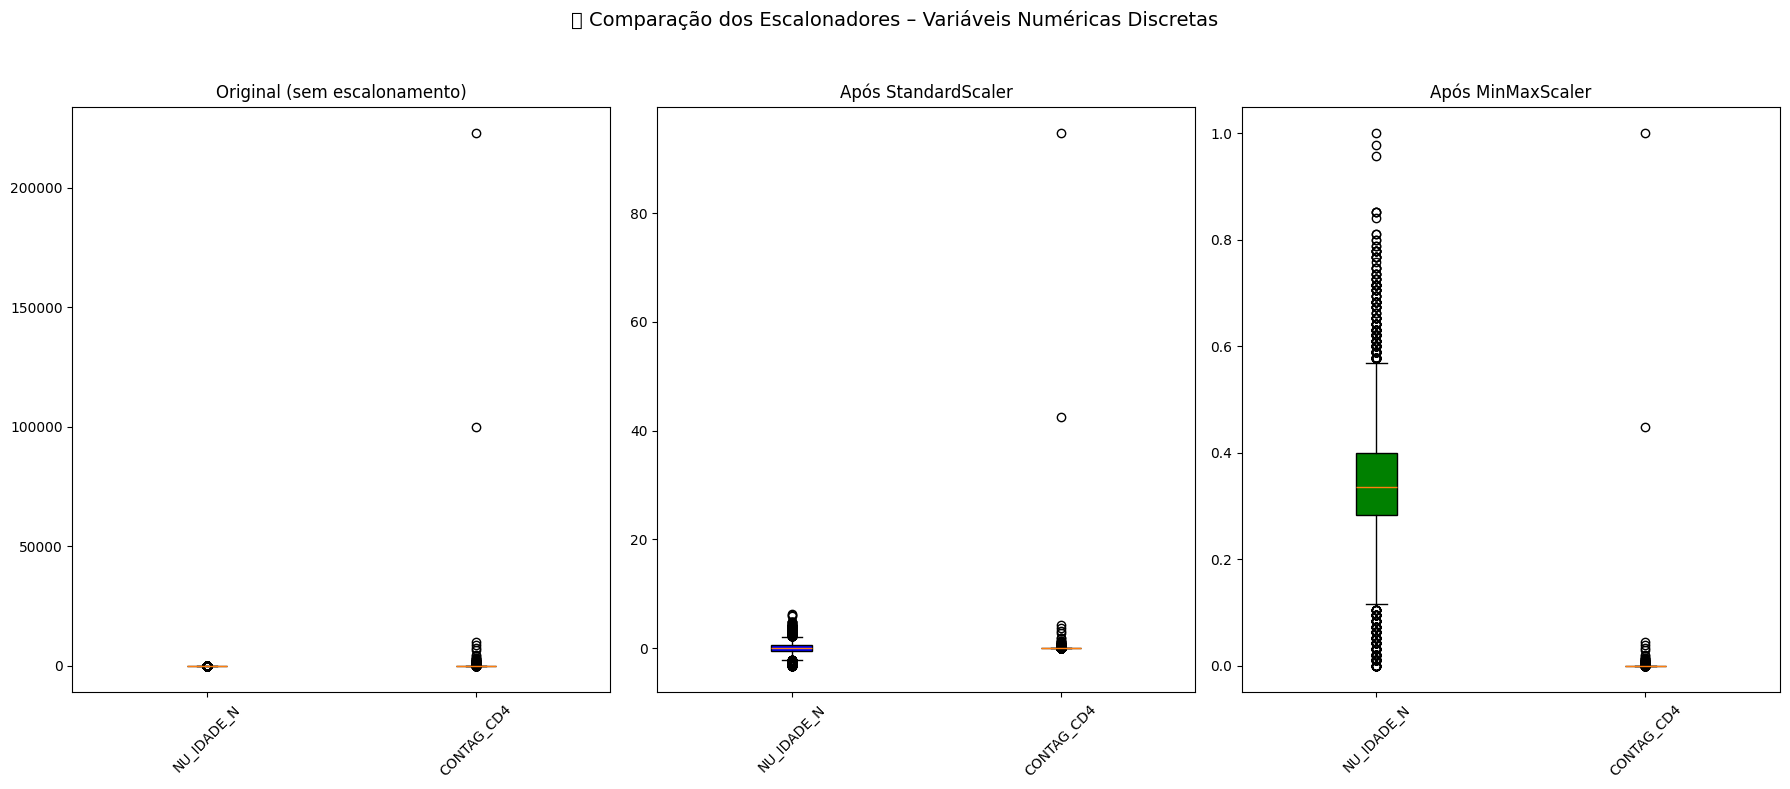


=== Estatísticas comparativas ===


Antes                          Pós-Std                        \
             Média    Desvio  Min       Max   Média Desvio    Min     Max   
NU_IDADE_N  32.652    10.023  0.0      95.0    -0.0    1.0 -3.258   6.221   
CONTAG_CD4  93.436  2352.481  0.0  222781.0    -0.0    1.0 -0.040  94.665   

           Pós-MinMax                   
                Média Desvio  Min  Max  
NU_IDADE_N      0.344  0.106  0.0  1.0  
CONTAG_CD4      0.000  0.011  0.0  1.0

In [25]:
# 📊 Comparação gráfica e estatística dos escalonadores

# Usar diretamente as colunas numéricas discretas já definidas
focus_vars = numerical_discrete_cols  # Ex.: ["NU_IDADE_N", "CONTAG_CD4"]

FIGSIZE = (18, 8)  # Altura fixa, já que será só uma linha de gráficos
figsPerLine = 3    # Número de figuras por linha

colors = ["lightgreen", "blue", "green"]
titles = ["Original (sem escalonamento)", "Após StandardScaler", "Após MinMaxScaler"]

scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

# Aplicar transformações e manter nomes das colunas
df_scaled_std = pd.DataFrame(
    scaler_std.fit_transform(df_atribsel[focus_vars].astype(float)),
    columns=focus_vars
)
df_scaled_mm = pd.DataFrame(
    scaler_mm.fit_transform(df_atribsel[focus_vars].astype(float)),
    columns=focus_vars
)

# ----------------------------------------------------------
# Boxplots lado a lado (Antes, Pós-Std, Pós-MinMax)
# ----------------------------------------------------------
datasets = {
    "Original (sem escalonamento)": df_atribsel[focus_vars].astype(float).values,
    "Após StandardScaler": df_scaled_std.values,
    "Após MinMaxScaler": df_scaled_mm.values
}

fig, axes = plt.subplots(1, figsPerLine, figsize=FIGSIZE)

for ax, (title, data), color in zip(axes, datasets.items(), colors):
    ax.boxplot(data, labels=focus_vars, vert=True, patch_artist=True,
               boxprops=dict(facecolor=color))
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("📊 Comparação dos Escalonadores – Variáveis Numéricas Discretas", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ----------------------------------------------------------
# Estatísticas comparativas em formato matricial
# ----------------------------------------------------------
def resumo_stats_matriz(df_before, df_std, df_mm, cols):
    stats = {}
    for col in cols:
        stats[col] = {
            ("Antes", "Média"):  df_before[col].mean(),
            ("Antes", "Desvio"): df_before[col].std(),
            ("Antes", "Min"):    df_before[col].min(),
            ("Antes", "Max"):    df_before[col].max(),

            ("Pós-Std", "Média"):  df_std[col].mean(),
            ("Pós-Std", "Desvio"): df_std[col].std(),
            ("Pós-Std", "Min"):    df_std[col].min(),
            ("Pós-Std", "Max"):    df_std[col].max(),

            ("Pós-MinMax", "Média"):  df_mm[col].mean(),
            ("Pós-MinMax", "Desvio"): df_mm[col].std(),
            ("Pós-MinMax", "Min"):    df_mm[col].min(),
            ("Pós-MinMax", "Max"):    df_mm[col].max(),
        }

    df_stats = pd.DataFrame(stats).T.round(3)
    df_stats.columns = pd.MultiIndex.from_tuples(df_stats.columns)  # cria hierarquia
    return df_stats

comparativo_stats_matriz = resumo_stats_matriz(
    df_atribsel[focus_vars], df_scaled_std, df_scaled_mm, focus_vars
)

print("\n=== Estatísticas comparativas ===")
display(comparativo_stats_matriz)


## 📌 Nota da seção – Escolha do escalonador para modelagem

- As variáveis numéricas do dataset (`NU_IDADE_N`, `CONTAG_CD4`) são **discretas** – não existem variáveis contínuas reais neste caso.

- Foram avaliadas duas estratégias de escalonamento: `StandardScaler` e `MinMaxScaler`.  
- A comparação gráfica e estatística mostrou que ambos funcionam conforme o esperado:
  - `Original (sem escalonamento)`: mantém médias, desvios, mínimos e máximos originais.
  - `StandardScaler`: centraliza variáveis em média ≈ 0 e desvio ≈ 1.  
    - _Útil para modelos que assumem distribuição aproximadamente gaussiana (ex.: Regressão Logística, Redes Neurais)._

  - `MinMaxScaler`: normaliza variáveis para o intervalo [0, 1].  
    - _Essencial para modelos baseados em distância (ex.: kNN, SVM)._


- **Decisão metodológica:**  
  - Ambos os escalonadores serão mantidos no pipeline de pré-processamento.  
  - A escolha final será feita na **Parte 2 (Modelagem)**, comparando o impacto de cada abordagem no desempenho dos modelos sensíveis à escala (ex.: kNN, SVM, Redes Neurais).
  
  ## 📌 Nota da seção – Impacto do escalonamento nas variáveis numéricas discretas

- A comparação foi feita em **dois níveis**:
  1. **Visual (boxplots)** → mostram a mudança da distribuição antes e depois de aplicar os escalonadores.
  2. **Numérica (tabela comparativa)** → confirma estatisticamente os efeitos esperados.
- **StandardScaler:**
- **MinMaxScaler:**
  - Normaliza cada variável para o intervalo **[0, 1]**.- **Decisão prática:**
  - O uso de ambos os escalonadores será considerado nos pipelines, avaliando impacto direto no desempenho dos modelos sensíveis à escala.


- As variáveis numéricas do dataset (`NU_IDADE_N`, `CONTAG_CD4`) são **discretas** – não existem variáveis contínuas reais neste caso.


---

## **Divisão de preditoras (X) e alvo (y)**

---

In [26]:
# 5.0 Divisão de preditoras (X) e alvo (y)
# ----------------------------------------
# - Objetivo: separar features (X) e variável-alvo (y).
# - Aqui você escolhe QUAL alvo quer balancear (hospitalização ou óbito).
# - Pré-requisito: df_encoded (ou df_enc) já codificado (OneHot) e sem colunas não-numéricas.
# - Observação: por ora, vamos seguir com 'target_hosp'; depois você pode trocar pelo alvo de óbito.

import pandas as pd

# Escolhe o alvo aqui:
target_col = "target_hosp"   # alternativas: "target_obito_any", "target_obito_mpx" (se estiverem com menor desbalanceamento)

# Verificações básicas
assert target_col in df_encoded.columns, f"Alvo '{target_col}' não existe em df_encoded."
assert set(df_encoded[target_col].dropna().unique()) <= {0,1}, "Alvo precisa ser binário (0/1)."

# Separa X e y
X = df_encoded.drop(columns=[target_col]).copy()
y = df_encoded[target_col].copy()

print("[5.0] X e y criados:", X.shape, y.shape)
print("Distribuição (%) do alvo selecionado:",
      (y.value_counts(normalize=True)*100).round(2).to_dict(), '\n')


[5.0] X e y criados: (10920, 1391) (10920,)
Distribuição (%) do alvo selecionado: {0: 97.32, 1: 2.68} 



---
## **Atividade 5: Balanceamento dos dados (Tomek e Smote)**
- Checar se os dados estão desbalanceados
- Aplicar os algoritmos Tomek e Smote
- Avaliar impacto no desempenho dos modelos treinados
---

### Checagem de desbalanceamento das classes


In [27]:
# 5.1 Checagem de desbalanceamento das classes
# --------------------------------------------
# - Objetivo: medir a proporção das classes antes de balancear.
# - Saída: distribuição percentual e alerta visual simples.

from collections import Counter

dist_original = (y.value_counts(normalize=True) * 100).round(2).to_dict()
print(f"\nVariável-alvo: {target_col}")
print("\n[5.1] Distribuição (%) do alvo (Original -> Pós-codificação/escalonamento):\n", dist_original)

# Regras práticas (heurística):
#   - Se min(classe) < 20% → dataset bastante desbalanceado
#   - Entre 20% e 40% → moderadamente desbalanceado
minority_pct = min(dist_original.values())
if minority_pct < 20:
    print("\n⚠️ Alerta: classe minoritária < 20% (desbalanceamento alto).")
elif minority_pct < 40:
    print("ℹ️ Observação: desbalanceamento moderado.")
else:
    print("✅ Classes relativamente equilibradas.")



Variável-alvo: target_hosp

[5.1] Distribuição (%) do alvo (Original -> Pós-codificação/escalonamento):
 {0: 97.32, 1: 2.68}

⚠️ Alerta: classe minoritária < 20% (desbalanceamento alto).


### 🔧 Sanitização e Imputação só para Balanceamento (garante só numéricos)

In [28]:
# 5.2 Sanitização/Imputação (só para balanceamento) + Escalonamento
# ------------------------------------------------------------------
# - Objetivo: garantir que X esteja 100% numérico e sem NaN antes do Tomek/SMOTE.
# - Passos:
#   1) Selecionar apenas colunas numéricas (df_encoded já tende a ser numérico após OneHot).
#   2) Imputar com mediana (robusta a outliers) — SOMENTE para esta etapa técnica.
#   3) Padronizar (StandardScaler) para que SMOTE/Tomek usem distâncias sem viés de escala.
# - Observação: Na modelagem final (cv/grid search), faremos TUDO em pipeline para evitar vazamento.

#import numpy as np
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler

# 1) Garante numéricos
X_num = X.select_dtypes(include=[np.number]).copy()
drop_cols = [c for c in X.columns if c not in X_num.columns]
if drop_cols:
    print(f"[5.2] Removidas do X (não numéricas para balanceamento): {drop_cols}")

# 2) Imputação simples (mediana)
imp_bal = SimpleImputer(strategy="median")
X_num_imp = pd.DataFrame(
    imp_bal.fit_transform(X_num),
    columns=X_num.columns,
    index=X_num.index
)

# 3) Escalonamento (StandardScaler)
scaler_bal = StandardScaler()
X_num_imp_scaled = pd.DataFrame(
    scaler_bal.fit_transform(X_num_imp),
    columns=X_num.columns,
    index=X_num.index
)

print("[5.2] X_num_imp_scaled pronto para Tomek/SMOTE:", X_num_imp_scaled.shape)

# (Opcional) Salvar artefatos técnicos desta etapa
# X_num_imp_scaled.to_csv("X_balance_ready.csv", index=False)
# y.to_csv("y_balance_ready.csv", index=False)


[5.2] Removidas do X (não numéricas para balanceamento): ['SINTOMA', 'faixa_etaria', 'regiao']
[5.2] X_num_imp_scaled pronto para Tomek/SMOTE: (10920, 1388)


### **Tomek Links (remoção de pares fronteira)**

In [29]:
# 5.3 Tomek Links
# ----------------
# - Objetivo: remover pares (maioria/minoria) que formam "bordas" ruidosas, deixando as classes mais separáveis.
# - Deve rodar APÓS escalonamento (distâncias ficam corretas).
# - Resultado: base levemente menor e menos ruído.

#from imblearn.under_sampling import TomekLinks

tl = TomekLinks(n_jobs=-1)
X_tomek, y_tomek = tl.fit_resample(X_num_imp_scaled, y)

dist_tomek = (y_tomek.value_counts(normalize=True) * 100).round(2).to_dict()
print("[5.3] Pós-Tomek — distribuição (%):", dist_tomek)
print("[5.3] Shape:", X_tomek.shape)


[5.3] Pós-Tomek — distribuição (%): {0: 97.31, 1: 2.69}
[5.3] Shape: (10892, 1388)


### **SMOTE (_Oversampling_ da Minoritária)**


In [30]:
# 5.4 Balanceamento com SMOTE (Synthetic Minority Oversampling Technique)
# ----------------------------------------------------------------------
# Objetivo: gerar amostras sintéticas da classe minoritária para reduzir desbalanceamento.
# Sequência recomendada: aplicar após Tomek Links (limpa ruídos/pares conflitantes),
#                        mas SMOTE também pode ser usado isoladamente.
# Param k_neighbors: nº de vizinhos usados para gerar pontos sintéticos.
#   - Ajuste dinâmico: k = min(5, minority_count - 1) → evita erro quando minoria tem poucos registros.
# Param random_state: garante reprodutibilidade.
# Obs: SMOTE não aceita 'n_jobs' (não paraleliza internamente).

#from imblearn.over_sampling import SMOTE

minority_count = y_tomek.value_counts().min()
k = min(5, max(1, minority_count - 1))

smote = SMOTE(k_neighbors=k, random_state=42)
X_tomek_smote, y_tomek_smote = smote.fit_resample(X_tomek, y_tomek)

dist_tomek_smote = (y_tomek_smote.value_counts(normalize=True) * 100).round(2).to_dict()
print("[5.4] Pós-Tomek/SMOTE — distribuição (%):", dist_tomek_smote)
print("[5.4] Shape:", X_tomek_smote.shape)


[5.4] Pós-Tomek/SMOTE — distribuição (%): {0: 50.0, 1: 50.0}
[5.4] Shape: (21198, 1388)


## 💾 Salvamento de Bases Balanceadas


In [31]:
# (Opcional) salvar bases balanceadas
pd.DataFrame(X_tomek, columns=X_num_imp_scaled.columns).to_csv("X_mpox_2022_target_hosp_tomek.csv", index=False)
y_tomek.to_csv("y_mpox_2022_target_hosp_tomek.csv", index=False)
pd.DataFrame(X_tomek_smote, columns=X_num_imp_scaled.columns).to_csv("X_mpox_2022_target_hosp_tomek_smote.csv", index=False)
y_tomek_smote.to_csv("y_mpox_2022_target_hosp_tomek_smote.csv", index=False)

## Auditoria comparativa de balanceamento: Antes → Tomek → SMOTE (Após Tomek)

=== Auditoria comparativa do balanceamento ===
                          0      1
Antes (%)             97.32   2.68
Após Tomek (%)        97.31   2.69
Após Tomek/SMOTE (%)  50.00  50.00


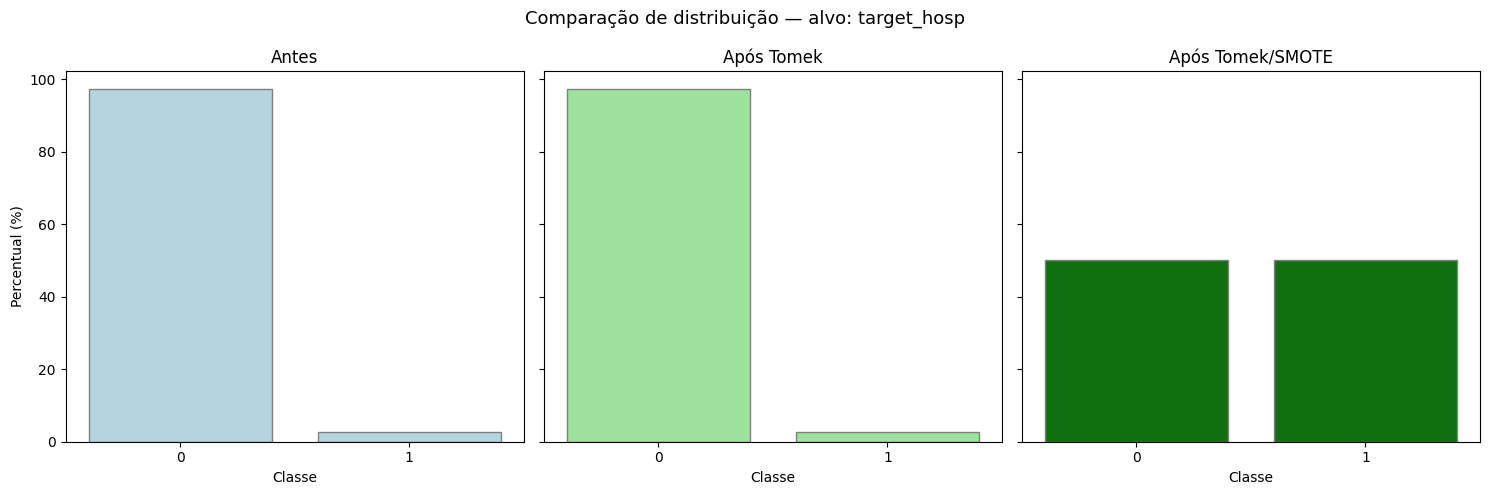

In [32]:
# 5.5 Auditoria comparativa (Antes → Tomek → SMOTE (Após Tomek))
# ------------------------------------------------
# - Objetivo: comparar a distribuição das classes ao longo das etapas de balanceamento.
# ------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dist_original = (y.value_counts(normalize=True) * 100).round(2).to_dict()
dist_tomek    = (y_tomek.value_counts(normalize=True) * 100).round(2).to_dict()
dist_tomek_smote    = (y_tomek_smote.value_counts(normalize=True) * 100).round(2).to_dict()

audit_balance = pd.DataFrame({
    "Antes (%)": dist_original,
    "Após Tomek (%)": dist_tomek,
    "Após Tomek/SMOTE (%)": dist_tomek_smote
}).T

print("=== Auditoria comparativa do balanceamento ===")
print(audit_balance)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.barplot(x=list(dist_original.keys()), y=list(dist_original.values()),
            ax=axes[0], color="lightblue", edgecolor="gray")
axes[0].set_title("Antes")

sns.barplot(x=list(dist_tomek.keys()), y=list(dist_tomek.values()),
            ax=axes[1], color="lightgreen", edgecolor="gray")
axes[1].set_title("Após Tomek")

sns.barplot(x=list(dist_tomek_smote.keys()), y=list(dist_tomek_smote.values()),
            ax=axes[2], color="green", edgecolor="gray")
axes[2].set_title("Após Tomek/SMOTE")

for ax in axes:
    ax.set_xlabel("Classe")
    ax.set_ylabel("Percentual (%)")

plt.suptitle(f"Comparação de distribuição — alvo: {target_col}", fontsize=13)
plt.tight_layout()
plt.show()


## 💾 Serialização dos dados balanceados (SMOTE)

In [33]:
# 💾 Serialização em Pickle (PKL) — Pós-SMOTE
# -------------------------------------------------
# Objetivo:
#   - Salvar os datasets balanceados em formato .pkl
#   - Preserva dtypes (ex: Int64, categorias) que podem se perder no CSV
# Saída:
#   - X_mpox_2022_target_hosp_tomek_smote.pkl
#   - y_mpox_2022_target_hosp_tomek_smote.pkl
# -------------------------------------------------

import joblib

# Caminhos de saída
X_tomek_smote_pkl = "X_mpox_2022_target_hosp_tomek_smote.pkl"
y_tomek_smote_pkl = "y_mpox_2022_target_hosp_tomek_smote.pkl"

# Serializa com joblib (mais eficiente para DataFrames grandes)
joblib.dump(pd.DataFrame(X_tomek_smote, columns=X_num_imp_scaled.columns), X_tomek_smote_pkl)
joblib.dump(y_tomek_smote, y_tomek_smote_pkl)

print(f"✔️ X_tomek_smote salvo em: {X_tomek_smote_pkl}")
print(f"✔️ y_tomek_smote salvo em: {y_tomek_smote_pkl}")

# Checagem pós-salvamento
X_check = joblib.load(X_tomek_smote_pkl)
y_check = joblib.load(y_tomek_smote_pkl)

print("\nChecagem pós-salvamento PKL:")
print("X_tomek_smote:", X_check.shape, "→ dtypes:", X_check.dtypes.unique())
print("y_tomek_smote:", y_check.shape, "→ dtype:", y_check.dtypes)
print(f"\nDistribuição alvo ({y_tomek_smote_pkl[0:-4]}):")
print("🎯Variável-alvo:", )
print(y_check.value_counts(normalize=True) * 100)


✔️ X_tomek_smote salvo em: X_mpox_2022_target_hosp_tomek_smote.pkl
✔️ y_tomek_smote salvo em: y_mpox_2022_target_hosp_tomek_smote.pkl

Checagem pós-salvamento PKL:
X_tomek_smote: (21198, 1388) → dtypes: [dtype('float64')]
y_tomek_smote: (21198,) → dtype: int64

Distribuição alvo (y_mpox_2022_target_hosp_tomek_smote):
🎯Variável-alvo:
target_hosp
0    50.0
1    50.0
Name: proportion, dtype: float64


---
## **Atividade 6: Treinamento dos modelos de Machine Learning**
- Comparar modelos: testar diferentes classificadores
    - Classificação binária
    - Modelos: Naive Bayes, Árvore de Decisão, Random Forest, Aprendizagem baseada em instâncias - kNN, Regressão logística, SVM, Redes Neurais Artificiais
- Medir desempenho com métricas adequadas e evitar overfitting
- Investigar como técnicas de imputação e codificação impactam os resultados
- Escolher e ajustar modelos (gridsearch/validação cruzada)
---

Configuração Inicial:

- 📦 Importação das bibliotecas
- 🔄 Carregar dados já pré-processados (Tomek + SMOTE aplicados)
- ✂️ Divisão treino/teste


In [34]:
# ================================
# 📦 Importação das bibliotecas
# ================================
# pandas/numpy → manipulação de dados
import pandas as pd
import numpy as np

# sklearn → modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

# visualização
import matplotlib.pyplot as plt
import seaborn as sns

# salvar/carregar modelos
import joblib

# ================================
# 🔄 Carregar dados já pré-processados (Tomek + SMOTE aplicados)
# ================================
X = joblib.load("/content/X_mpox_2022_target_hosp_tomek_smote.pkl")
y = joblib.load("/content/y_mpox_2022_target_hosp_tomek_smote.pkl")

# ================================
# ✂️ Divisão treino/teste
# - Mantemos proporção de classes (stratify=y)
# - 80% treino, 20% teste
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)
print("Distribuição classes (treino):\n", y_train.value_counts(normalize=True))


Tamanho treino: (16958, 1388)  | Tamanho teste: (4240, 1388)
Distribuição classes (treino):
 target_hosp
1    0.5
0    0.5
Name: proportion, dtype: float64


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Função auxiliar de avaliação

In [36]:
def avaliar_modelo(modelo, X_train, y_train, X_test, y_test, nome_modelo):
    """
    Treina e avalia um modelo de classificação.

    Passos:
    1. Treina com dados de treino.
    2. Prediz nos dados de teste.
    3. Calcula métricas (Accuracy, Precision, Recall, F1, AUC).
    4. Exibe relatório, matriz de confusão e curva ROC.

    Retorna: dicionário com métricas principais (para comparação entre modelos).
    """
    # Treinamento do modelo
    modelo.fit(X_train, y_train)

    # Predição
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    # Cálculo das métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Exibição de resultados
    print(f"\n📊 Resultados - {nome_modelo}")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    print(f"AUC: {auc:.3f}")

    # Curva ROC (quando disponível)
    if y_proba is not None:
        RocCurveDisplay.from_estimator(modelo, X_test, y_test)
        plt.title(f"Curva ROC - {nome_modelo}")
        plt.show()

    # Retorno para comparação final
    return {"Modelo": nome_modelo, "Accuracy": acc, "Precision": prec,
            "Recall": rec, "F1": f1, "AUC": auc}

# Lista para armazenar os resultados de todos os modelos
resultados = []


In [37]:
# Visualização rápida
print(X.head(1))
print(y.value_counts())

#type(X_loaded)
#type(y_loaded)


   NU_IDADE_N   SIFILIS  CONTAG_CD4  SINTOMA_missing  OUTRO_DES_missing  \
0    0.134523 -0.289047    0.261253        -0.126876           0.293487   

   PROFIS_SAUDE_missing  LOCAL_CONT_missing  TRANSM_missing  \
0              -2.68985            -2.68985       -0.115191   

   CONTAT_ANIMAL_missing  CARACT_GENOMICA_missing  ...  SG_UF_NOT_PR  \
0              -0.115191                -0.115191  ...     -0.219054   

   SG_UF_NOT_RJ  SG_UF_NOT_RN  SG_UF_NOT_RO  SG_UF_NOT_RR  SG_UF_NOT_RS  \
0     -0.382854     -0.113548     -0.027077     -0.023447     -0.178993   

   SG_UF_NOT_SC  SG_UF_NOT_SE  SG_UF_NOT_SP  SG_UF_NOT_TO  
0     -0.208514      -0.08316     -0.796853     -0.040633  

[1 rows x 1388 columns]
target_hosp
0    10599
1    10599
Name: count, dtype: int64


🔹 1. Naive Bayes

📘 Teoria: assume independência condicional entre atributos (Kelleher, cap. 8).
Bom para baseline rápido, mesmo que a suposição seja simplista.


📊 Resultados - Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2120
           1       1.00      1.00      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2119    1]
 [   0 2120]]
AUC: 1.000


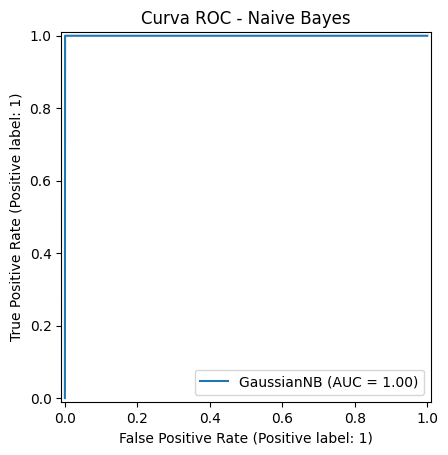

In [38]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
resultados.append(avaliar_modelo(nb, X_train, y_train, X_test, y_test, "Naive Bayes"))


🔹 2. Regressão Logística

📘 Teoria: modelo linear que estima probabilidades. Muito usado em saúde pela interpretabilidade (odds ratio).


📊 Resultados - Regressão Logística
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2120
           1       0.98      1.00      0.99      2120

    accuracy                           0.99      4240
   macro avg       0.99      0.99      0.99      4240
weighted avg       0.99      0.99      0.99      4240

Matriz de Confusão:
 [[2080   40]
 [   0 2120]]
AUC: 1.000


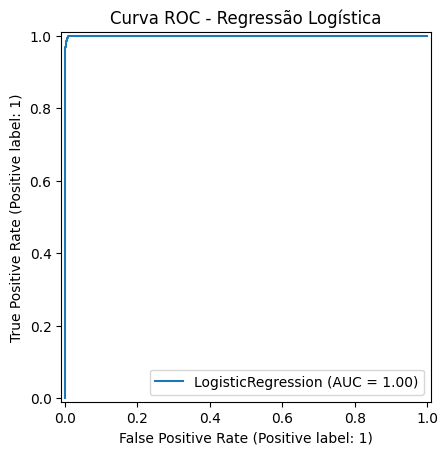

In [39]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
resultados.append(avaliar_modelo(log_reg, X_train, y_train, X_test, y_test, "Regressão Logística"))


🔹 3. Árvore de Decisão

📘 Teoria: gera regras hierárquicas “if-then”. Boa interpretabilidade, mas risco de overfitting se não podada.


📊 Resultados - Árvore de Decisão
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2120
           1       1.00      1.00      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2119    1]
 [   7 2113]]
AUC: 0.998


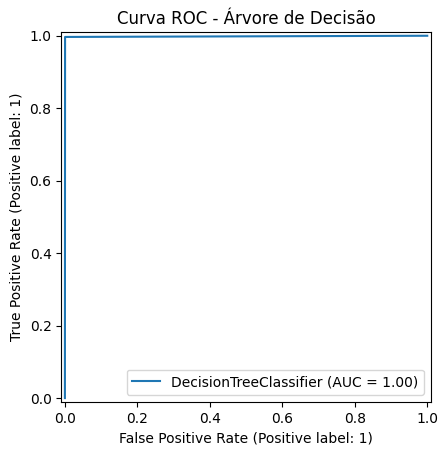

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
resultados.append(avaliar_modelo(tree, X_train, y_train, X_test, y_test, "Árvore de Decisão"))


🔹 4. kNN

📘 Teoria: classifica pelo “voto” dos vizinhos mais próximos. Simples, mas sensível a escala e dados ruidosos


📊 Resultados - kNN
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2120
           1       0.97      1.00      0.99      2120

    accuracy                           0.99      4240
   macro avg       0.99      0.99      0.99      4240
weighted avg       0.99      0.99      0.99      4240

Matriz de Confusão:
 [[2064   56]
 [   0 2120]]
AUC: 0.996


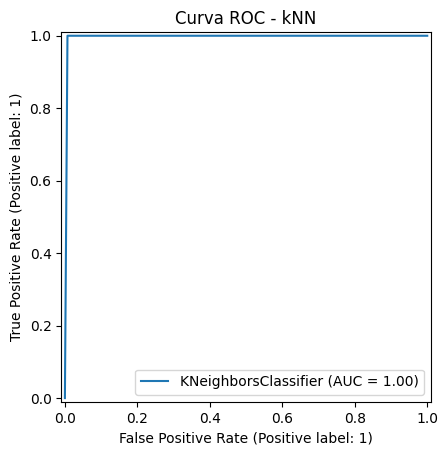

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # k=5 é default, pode ser ajustado
resultados.append(avaliar_modelo(knn, X_train, y_train, X_test, y_test, "kNN"))


🔹 5. Random Forest

📘 Teoria: conjunto de várias árvores de decisão com amostragem aleatória. Reduz overfitting, aumenta robustez


📊 Resultados - Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2120
           1       1.00      0.99      1.00      2120

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240

Matriz de Confusão:
 [[2114    6]
 [  11 2109]]
AUC: 1.000


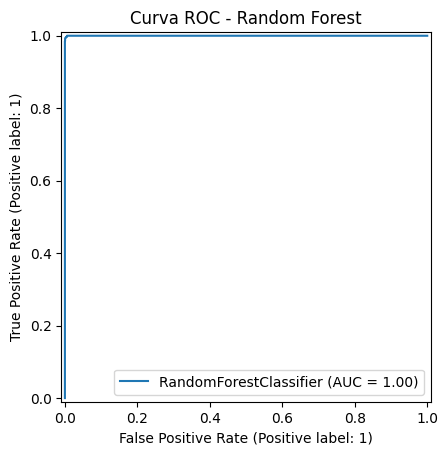

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
resultados.append(avaliar_modelo(rf, X_train, y_train, X_test, y_test, "Random Forest"))


🔹 6. SVM

📘 Teoria: encontra hiperplano ótimo para separar classes. Potente em dados complexos, mas exige tuning (kernel, C, γ).

In [ ]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)  # probability=True para permitir ROC
resultados.append(avaliar_modelo(svm, X_train, y_train, X_test, y_test, "SVM"))


🔹 7. Rede Neural (MLP)

📘 Teoria: modelo inspirado no cérebro humano, com múltiplas camadas ocultas. Captura padrões complexos, mas menos interpretável.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
resultados.append(avaliar_modelo(mlp, X_train, y_train, X_test, y_test, "Rede Neural (MLP)"))


🔹 Comparação final entre modelos

In [ ]:
# Criar DataFrame comparativo
df_resultados = pd.DataFrame(resultados)

print("\n📊 Comparação de Métricas entre Modelos")
display(df_resultados.sort_values(by="F1", ascending=False))


---
## **Atividade 7: Usar o modelo treinado**
- Salvar os transformadores
- Salvar o modelo
- Fazer predição usando dados novos
---


Naive Bayes

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = nb

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


SVM

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = nb

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Árvore de Decisão

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = tree

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Rede Neural (MLP)

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = mlp

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_mlp.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_mlp.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Random Forest

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = rf

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_rf.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_rf.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Regressão Logística

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = log_reg

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_log_reg.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_log_reg.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


kNN

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = knn

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_knn.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_knn.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


In [ ]:
import os

# ================================
# 📂 Criar pasta para salvar os modelos
# ================================
os.makedirs("modelos_salvos", exist_ok=True)

# ================================
# 🔄 Loop para salvar e recarregar todos os modelos
# ================================
modelos_treinados = {
    "NaiveBayes": nb,
    "RegressaoLogistica": log_reg,
    "ArvoreDecisao": tree,
    "kNN": knn,
    "RandomForest": rf,
    "SVM": svm,
    "RedeNeuralMLP": mlp
}

for nome, modelo in modelos_treinados.items():
    print(f"\n=== 🔄 Testando reuso do modelo: {nome} ===")

    # 1. Salvar modelo em arquivo PKL
    caminho = f"modelos_salvos/{nome}.pkl"
    joblib.dump(modelo, caminho)
    print(f"✅ Modelo salvo em: {caminho}")

    # 2. Recarregar modelo salvo
    modelo_carregado = joblib.load(caminho)

    # 3. Testar predição em uma pequena amostra (5 registros de teste)
    amostra = X_test.iloc[:5]
    pred = modelo_carregado.predict(amostra)
    proba = modelo_carregado.predict_proba(amostra)[:,1] if hasattr(modelo_carregado, "predict_proba") else "N/A"

    print("🔮 Predições:", pred)
    print("📊 Probabilidades:", proba)
